#### Imports


In [1]:
from zoish.feature_selectors.single_feature_selectors import SingleFeaturePerformanceFeatureSelector
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from category_encoders import OrdinalEncoder
import xgboost
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from sklearn.linear_model import LinearRegression

2023-02-24 20:10:09,678 :: matplotlib :: matplotlib data path: /Users/hjavedani/Documents/zoish/.venv/lib/python3.10/site-packages/matplotlib/mpl-data
2023-02-24 20:10:09,689 :: matplotlib :: CONFIGDIR=/Users/hjavedani/.matplotlib
2023-02-24 20:10:09,695 :: matplotlib :: interactive is False
2023-02-24 20:10:09,697 :: matplotlib :: platform is darwin
2023-02-24 20:10:09,698 :: matplotlib :: loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'posix', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '_abc', 'abc', 'io', '__main__', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_virtualenv', '_distutils_hack', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib._abc', 'itertools', 'keyword', '_operator', 'operator', 'reprlib', '_colle

#### Computer Hardware Data Set (a regression problem)
  
###### https://archive.ics.uci.edu/ml/datasets/Computer+Hardware

In [2]:
urldata= "https://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data"
# column names
col_names=[
    "vendor name",
    "Model Name",
    "MYCT",
    "MMIN",
    "MMAX",
    "CACH",
    "CHMIN",
    "CHMAX",
    "PRP"
]
# read data
data = pd.read_csv(urldata,header=None,names=col_names,sep=',')


#### Train test split

In [3]:
X = data.loc[:, data.columns != "PRP"]
y = data.loc[:, data.columns == "PRP"]


X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.33, random_state=42)


#### Define feature selector step 


In [4]:
single_feature_performance_feature_selector_factory = (
    SingleFeaturePerformanceFeatureSelector.single_feature_performance_feature_selector_factory.set_model_params(
        X=X_train,
        y=y_train,
        verbose=10,
        random_state=0,
        estimator=xgboost.XGBRegressor(),
        estimator_params={
            "max_depth": [4, 5],
        },
        fit_params = {
            "callbacks": None,
        },
        method="tunegridsearch",
        # if n_features=None only the threshold will be considered as a cut-off of features grades.
        # if threshold=None only n_features will be considered to select the top n features.
        # if both of them are set to some values, the threshold has the priority for selecting features.
        n_features=5,
        threshold = None,
        list_of_obligatory_features_that_must_be_in_model=[],
        list_of_features_to_drop_before_any_selection=[],
    ).set_single_feature_params(
        cv=3,
        variables=None,
        scoring='roc_auc',
        confirm_variables=True,
        
    )
    .set_tunegridsearchcv_params(
        verbose=1,
        n_jobs=None,
        cv=3,
        early_stopping=None, 
        scoring='r2', 
        refit=True, 
        error_score='raise', 
        return_train_score=False, 
        local_dir='~/ray_results', 
        name=None, 
        max_iters=1, 
        use_gpu=False, 
        loggers=None, 
        pipeline_auto_early_stop=True, 
        stopper=None, 
        time_budget_s=None, 
        measure_of_accuracy=None,
        mode=None

)
)

#### Find feature types for later use

In [5]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()
cat_cols =  X_train.select_dtypes(include=['object']).columns.tolist()


#### Define pipeline

In [6]:


pipeline =Pipeline([
            # int missing values imputers
            ('intimputer', MeanMedianImputer(
                imputation_method='median', variables=int_cols)),
            # category missing values imputers
            ('catimputer', CategoricalImputer(variables=cat_cols)),
            #
            ('catencoder', OrdinalEncoder()),
            # feature selection
            ("sfpfsf", single_feature_performance_feature_selector_factory),
            # add any regression model from sklearn e.g., LinearRegression
            ('regression', LinearRegression())


 ])



#### Run Pipeline

In [7]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)


2023-02-24 20:10:52,821	INFO tune.py:762 -- Total run time: 24.38 seconds (22.73 seconds for the tuning loop).


2023-02-24 20:10:53,092 :: dev :: The optimization will be based on r2 metric!
2023-02-24 20:10:53,092 :: dev :: The optimization will be based on r2 metric!


/Users/hjavedani/Documents/zoish/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['MMIN', 'MMAX', 'CACH', 'MYCT', 'CHMAX']


#### plot

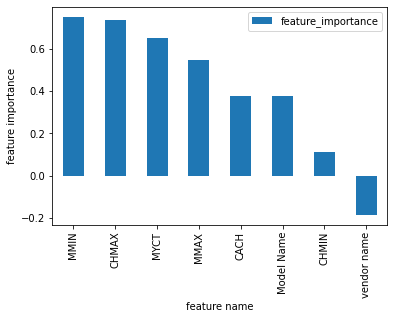

SingleFeaturePerformanceFeatureSelector(X=               vendor name  Model Name  MYCT   MMIN  MMAX  CACH  CHMIN  CHMAX
cdc          cyber:170/845          64  5240  20970    30    12     24    208
c.r.d      universe:68/137         320   512   5000     4     1      5     77
cambex             1641-11          50  2000  16000     8     3      6     52
ibm                4341-12         185  2000  16000    16     1      6     76
ibm                 3083:e          26  8000  16000     0     8     16    185
...                    ...         ...   ...    ...   ...   ...    ...    ...
ibm                   38/8         400  4000   8000     0     1      1     32
bti                   5000         350    64     64     0     1      4     10
honeywell         dps:8/20         140  2000   4000     8     1     20     22
prime...
                                        list_of_features_to_drop_before_any_selection=[],
                                        list_of_obligatory_features_that_must_be_in_model=[],
                                        local_dir='~/ray_results', max_iters=1,
                                        method='tunegridsearch', n_features=5,
                                        pipeline_auto_early_stop=True,
                                        random_state=0, refit=True,
                                        return_train_score=False, scoring='r2',
                                        use_gpu=False, verbose=1,
                                        y=           PRP
cdc        136
c.r.d       28
cambex      74
ibm         76
ibm        113
...        ...
ibm         45
bti         15
honeywell   32
prime       43
ibm         18

[140 rows x 1 columns])

In [8]:
SingleFeaturePerformanceFeatureSelector.single_feature_performance_feature_selector_factory.plot_features_all(
    path_to_save_plot="../plots/single_random_search_classification"
)


#### Check performance of the Pipeline

In [9]:
print('r2 score : ')
print(r2_score(y_test,y_pred))


r2 score : 
0.9199440731541855


#### Get list of features and grades

In [10]:
SingleFeaturePerformanceFeatureSelector.single_feature_performance_feature_selector_factory.get_info_of_features_and_grades()

list of selected features+list of obligatory features that must be in                 model-list of features to drop before any selection               ['MMIN', 'MMAX', 'CACH', 'MYCT', 'CHMAX']
list of selected features and their grades
---------------------------------------------------------
  column_name feature_importance
3        MMIN           0.750359
7       CHMAX           0.737425
2        MYCT           0.651242
4        MMAX           0.545461
5        CACH           0.376021
Note: list of obligatory features that must be in model-list of                         features to drop before any selection also has considered !


SingleFeaturePerformanceFeatureSelector(X=               vendor name  Model Name  MYCT   MMIN  MMAX  CACH  CHMIN  CHMAX
cdc          cyber:170/845          64  5240  20970    30    12     24    208
c.r.d      universe:68/137         320   512   5000     4     1      5     77
cambex             1641-11          50  2000  16000     8     3      6     52
ibm                4341-12         185  2000  16000    16     1      6     76
ibm                 3083:e          26  8000  16000     0     8     16    185
...                    ...         ...   ...    ...   ...   ...    ...    ...
ibm                   38/8         400  4000   8000     0     1      1     32
bti                   5000         350    64     64     0     1      4     10
honeywell         dps:8/20         140  2000   4000     8     1     20     22
prime...
                                        list_of_features_to_drop_before_any_selection=[],
                                        list_of_obligatory_features_that_must_be_in_model=[],
                                        local_dir='~/ray_results', max_iters=1,
                                        method='tunegridsearch', n_features=5,
                                        pipeline_auto_early_stop=True,
                                        random_state=0, refit=True,
                                        return_train_score=False, scoring='r2',
                                        use_gpu=False, verbose=1,
                                        y=           PRP
cdc        136
c.r.d       28
cambex      74
ibm         76
ibm        113
...        ...
ibm         45
bti         15
honeywell   32
prime       43
ibm         18

[140 rows x 1 columns])

#### Only list of selected features is :

In [11]:
print(SingleFeaturePerformanceFeatureSelector.single_feature_performance_feature_selector_factory.get_list_of_features())

['MMIN', 'MMAX', 'CACH', 'MYCT', 'CHMAX']


#### Get access to feature selector instance

In [12]:
print(SingleFeaturePerformanceFeatureSelector.single_feature_performance_feature_selector_factory.get_feature_selector_instance())

SelectBySingleFeaturePerformance(confirm_variables=True,
                                 estimator=XGBRegressor(base_score=0.5,
                                                        booster='gbtree',
                                                        callbacks=None,
                                                        colsample_bylevel=1,
                                                        colsample_bynode=1,
                                                        colsample_bytree=1,
                                                        early_stopping_rounds=None,
                                                        enable_categorical=False,
                                                        eval_metric=None,
                                                        gamma=0, gpu_id=-1,
                                                        grow_policy='depthwise',
                                                        importance_type=None,
                     

#### Get list of features and grades

In [13]:
SingleFeaturePerformanceFeatureSelector.single_feature_performance_feature_selector_factory.get_info_of_features_and_grades()

list of selected features+list of obligatory features that must be in                 model-list of features to drop before any selection               ['MMIN', 'MMAX', 'CACH', 'MYCT', 'CHMAX']
list of selected features and their grades
---------------------------------------------------------
  column_name feature_importance
3        MMIN           0.750359
7       CHMAX           0.737425
2        MYCT           0.651242
4        MMAX           0.545461
5        CACH           0.376021
Note: list of obligatory features that must be in model-list of                         features to drop before any selection also has considered !


SingleFeaturePerformanceFeatureSelector(X=               vendor name  Model Name  MYCT   MMIN  MMAX  CACH  CHMIN  CHMAX
cdc          cyber:170/845          64  5240  20970    30    12     24    208
c.r.d      universe:68/137         320   512   5000     4     1      5     77
cambex             1641-11          50  2000  16000     8     3      6     52
ibm                4341-12         185  2000  16000    16     1      6     76
ibm                 3083:e          26  8000  16000     0     8     16    185
...                    ...         ...   ...    ...   ...   ...    ...    ...
ibm                   38/8         400  4000   8000     0     1      1     32
bti                   5000         350    64     64     0     1      4     10
honeywell         dps:8/20         140  2000   4000     8     1     20     22
prime...
                                        list_of_features_to_drop_before_any_selection=[],
                                        list_of_obligatory_features_that_must_be_in_model=[],
                                        local_dir='~/ray_results', max_iters=1,
                                        method='tunegridsearch', n_features=5,
                                        pipeline_auto_early_stop=True,
                                        random_state=0, refit=True,
                                        return_train_score=False, scoring='r2',
                                        use_gpu=False, verbose=1,
                                        y=           PRP
cdc        136
c.r.d       28
cambex      74
ibm         76
ibm        113
...        ...
ibm         45
bti         15
honeywell   32
prime       43
ibm         18

[140 rows x 1 columns])